# AI vs Human Text Classification using Machine Learning

This notebook demonstrates the process of processing texts into machine-readable data and feeding it into 3 different models to train them before reviewing their performance. The 3 models are: Support Vector Machine (SVM), Decision Tree, and AdaBoost.

## Import Libraries

In [1]:
# Misc imports
from os import path  # cross-platform file path handling
import time          # measure training and testing time

# Data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Text processing
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import string

# Machine learning
from sklearn.model_selection import ( train_test_split, GridSearchCV, cross_val_score, StratifiedKFold )
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ( accuracy_score, classification_report, confusion_matrix, f1_score,
        roc_auc_score, roc_curve, precision_recall_curve, precision_score, recall_score, PrecisionRecallDisplay )

import joblib

# Download necessary NLTK resources for text processing
nltk.download("wordnet") # WordNet for lemmatization
nltk.download("punkt") # Tokenizer
nltk.download("punkt_tab")
nltk.download("stopwords") # Stopwords for text cleaning
nltk.download("averaged_perceptron_tagger") # POS tagger for part-of-speech tagging
nltk.download("averaged_perceptron_tagger_eng") # Additional tagger for English

[nltk_data] Downloading package wordnet to /home/sang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/sang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/sang/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/sang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

## Stat Class for Displaying Model Metrics and Plots

In [2]:
class Stat():
    def __init__(self, model_name, y_true_val=None, y_score=None):
        self.model_name = model_name

        if not y_true_val is None or not y_score is None:
            self.update_stat(y_true_val, y_score)
        
    
    def update_stat(self, new_y_val, new_y_score):
        """
            Create scores and store them in the class
        """
        self.y_true = new_y_val
        self.y_pred = new_y_score
        self.accuracy = accuracy_score(new_y_val, new_y_score)
        self.precision = precision_score(new_y_val, new_y_score)
        self.recall = recall_score(new_y_val, new_y_score)
        self.f1_macro = f1_score(new_y_val, new_y_score, average="macro")
        self.f1_weighted = f1_score(new_y_val, new_y_score, average="weighted")
        self.confusion_matrix = confusion_matrix(new_y_val, new_y_score)
        self.roc_auc_score = roc_auc_score(new_y_val, new_y_score)


    def print_stat(self):
        """
            Print the scores, confusion matrix, and classification report
        """
        print(f"Accuracy Score:\t\t{self.accuracy*100:.2f}%")
        print(f"Precision Score:\t{self.precision*100:.2f}%")
        print(f"Recall Score:\t\t{self.recall*100:.2f}%")
        print(f"F1-score (macro):\t{self.f1_macro*100:.2f}%")
        print(f"F1-score (weighted):\t{self.f1_weighted*100:.2f}%")
        print(f"ROC AUC Score:\t\t{self.roc_auc_score*100:.2f}%")
        print("Confusion Matrix:\n", self.confusion_matrix)
        print(classification_report(self.y_true, self.y_pred, target_names=["Human", "AI"]))


    def plot_roc_curve(self):
        # Calculate ROC curve and ROC AUC
        fpr, tpr, thresholds = roc_curve(self.y_true, self.y_pred)
    
        # Plot the ROC curve
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC curve (area = {self.roc_auc_score:.2f}")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for {self.model_name}")
        plt.legend()
        plt.show()

    
    def plot_precision_recall(self):
        PrecisionRecallDisplay.from_predictions(self.y_true, self.y_pred)
        plt.title(f"Precision-Recall Curve for {self.model_name}")
        plt.show()

    
    def create_row(self):
        """
            Creates a row to be used in a comparison table
        """
        return [self.model_name, self.accuracy, self.precision, self.recall,
                   self.f1_macro, self.f1_weighted, self.roc_auc_score]

    
    def create_comparison_table(self, other_stat):
        """
            Creates a comparison table between this model and
            the `other_stat` model using pandas DataFrame
        """
        data = [self.create_row(), other_stat.create_row()]

        return pd.DataFrame(data, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score (macro)", "F1-score (weighted)", "ROC AUC Score"])

## Set Global Variables

In [3]:
# Data Path Variables
DATA_PATH = path.join("..", "data")
TRAIN_CSV = path.join(DATA_PATH, "AI_vs_huam_train_dataset.csv")

# Model Path Variables
MODELS_PATH = path.join("..", "models")
SVM_PATH = path.join(MODELS_PATH, "model_ml_Support Vector Machine.pkl")
DT_PATH = path.join(MODELS_PATH, "model_ml_Decision Tree.pkl")
ADA_PATH = path.join(MODELS_PATH, "model_ml_AdaBoost.pkl")

VECTOR_PATH = path.join(MODELS_PATH, "tfidf.pkl")

---

## 1. Data Analysis & Preprocessing

### 1.1. Data Analysis

In [4]:
# Load the training data for analysis
df_train = pd.read_csv(TRAIN_CSV)

# Describe statistics of the data
df_train.describe()

,label
count,3728.000000
mean,0.500000
std,0.500067
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [5]:
# Print first 5 samples
df_train.head()

,essay,label
0,International sports events require the most w...,0
1,Globalisation has become a significant aspect ...,0
2,There is an ever-increasing number of bullying...,0
3,"It is commonly believed, that companies should...",0
4,Despite knowing about the adverse effects of c...,0


In [6]:
# Print last 5 samples
df_train.tail()

,essay,label
3723,I agree that successful people are willing to ...,1
3724,I believe that people who are open to trying n...,1
3725,"To succeed in life, we must do everything poss...",1
3726,"I'm not entirely sure what the word ""successfu...",1
3727,The key to success is trying new things while ...,1


### 1.2. Preprocessing

#### 1.2.1. Preprocessing Functions

In [7]:
# Create the lemmatizer object for lemmatization
lemmatizer = WordNetLemmatizer()

# Compile regex objects to remove non-latin characters
single_quote_expr = re.compile(r'[\u2018\u2019]', re.U)
unicode_chars_expr = re.compile(r'[\u0080-\uffff]', re.U)

Define a set of functions for preprocess text to be used in a pipeline

In [8]:
def get_pos_tag(token):
    """
        Return the POS tag associated with the token
    """
    tag_dict = {
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "A": wordnet.ADJ,
        "R": wordnet.ADV
    }

    tag = nltk.pos_tag([token])[0][1][0]
    return tag_dict.get(tag, wordnet.NOUN)


def lemmatize_text(texts):
    """
        Converts text to lemmatized version to prepare it for vectorization
    """
    x = []

    for text in texts:
        tokens = word_tokenize(text)
    
        lemma_tokens = []
        for token in tokens:
            pos_tag = get_pos_tag(token)
            lemma_tokens.append(lemmatizer.lemmatize(token, pos_tag))

        x.append(" ".join(lemma_tokens))

    return np.array(x)


def clean_text(texts):
    """
        Convert text to lowercase, removes punctuations and special characters
    """
    x = []
    
    for text in texts:
        # Return empty string if text is not a string
        if not isinstance(text, str):
            x.append("")
            continue
        
        # Remove non-latin characters
        tmp = single_quote_expr.sub("'", text, re.U)
        tmp = unicode_chars_expr.sub("", tmp, re.U)
    
        # Convert text to lowercase
        tmp = tmp.lower()
    
        # Remove numbers, decimals, and mixed words
        # Also strips the text of leading whitespaces
        # i.e. 123, 12.345, mi123x, 123mix, mix123
        tmp = " ".join([
            word for word in tmp.strip().split() if not re.match(r"(\d+.*|\w+(\d+.*)+)", word)
        ])
    
        # Remove punctuations and special characters
        tmp = re.sub(rf"[{ string.punctuation }]", "", tmp)
    
        # Remove stopwords
        #STOPWORDS = stopwords.words("english")
        stop_words = stopwords.words("english")
        tmp = " ".join([
            word for word in tmp.split() if not word in stop_words
        ])

        x.append(tmp)

    return np.array(x)

def preprocess_text(texts):
    cleaned = clean_text(texts)
    return lemmatize_text(cleaned)

#### 1.2.2. Demonstrate Text Preprocessing

In [9]:
# Retrieve the first essay as a sample
sample = np.array([df_train["essay"][0]])

# Apply text preprocessing to the sample
processed = preprocess_text(sample)

In [10]:
print("-- Original: --:", sample[0], end="\n\n")
print("-- Processed --:", processed[0])

-- Original: --: International sports events require the most well-trained athletes for each country, in order to achieve this goal countries make an effort to build infrastructure designed to train top athletes. Although this policy can indeed make fewer sports facilities for ordinary people, investing in the best athletes is vital to develop competitive sports performances in each country.
On the one hand, building specific infrastructure for the best athletes is crucial in order to get better results at international sports events such as The Olympics or the World Cup. The importance of getting better results is that it creates awareness of the importance of sports in society and motivates more people to do a sport. In this way, investing in these developments can help countries to develop an integral sport policy that can benefit everyone.
On the other hand, one can argue that a negative effect could be that less infrastructure is built for the rest of the people. However, people w

#### 1.2.3. Prepare Data for Model Input

In [11]:
# Create vectorizer object
vectorizer = TfidfVectorizer(
    max_features=4000,        # Keep top 5000 most important words
    ngram_range=(1, 2),       # Use single words and word pairs
    min_df=2,                 # Word must appear in at least 2 documents
    max_df=0.95,              # Ignore words that appear in >95% of documents
)

# Vectorizer the 

In [13]:
# Determine the input and output of the data
X = df_train["essay"]
y = df_train["label"]

# Split the data into training and testing datasets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Vectorizer the input features for use by AdaBoost
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

In [15]:
# Save the vectorizer
with open(VECTOR_PATH, "wb") as file:
    joblib.dump(vectorizer, file)

## 2. Model Development & Optimization

### 2.1. Model Development

#### 2.1.1. Set up the Models for Optimization

In [16]:
# Load the saved SVM model from Assignment 2
svm_model = joblib.load(SVM_PATH)

In [17]:
# Load the saved Decision Tree model from Assignment 2
dt_model = joblib.load(DT_PATH)

In [18]:
# Set up GridSearch parameters for AdaBoost
ada_params = {
    "n_estimators": [50, 100, 200, 500],
    "learning_rate": [0.5, 1.0, 1.25, 1.5, 2]
}

### 2.2. Optimization

Hyperparameterize all the AdaBoost model with its best parameters

In [19]:
# Create a GridSearchCV object
ada_grid = GridSearchCV(
    AdaBoostClassifier(random_state=42),
    ada_params,
    cv=5,
    scoring="accuracy",
    n_jobs=6,
    verbose=1
)

In [20]:
# Start hypertuned training of AdaBoost model if ada_grid exists
start_time = time.time()
ada_grid.fit(X_train_tfidf, y_train)

# Print results
print(f"""
GridSearch took {time.time() - start_time:.2f} seconds
Best parameters:
  {ada_grid.best_params_}
Best cross-validation score:
        {ada_grid.best_score_:.4f}
""")

# Save the hypertuned AdaBoost model into a variable
ada_model = ada_grid.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits

GridSearch took 368.32 seconds
Best parameters:
  {'learning_rate': 1.0, 'n_estimators': 500}
Best cross-validation score:
        0.9822



### 2.2.1. Evaluate with Testing Data

In [22]:
# Store the predictions for each models
y_pred_svm = svm_model.predict(X_val)
y_pred_dt = dt_model.predict(X_val)
y_pred_ada = ada_model.predict(X_val_tfidf)

In [23]:
# Create Stat objects for the 3 models and pass their scores
svm = Stat("Support Vector Machine", y_val, y_pred_svm)
dt = Stat("Decision Tree", y_val, y_pred_dt)
ada = Stat("AdaBoost", y_val, y_pred_ada)

In [24]:
# Update the accuracy metrics for each models
svm.update_stat(y_val, y_pred_svm)
dt.update_stat(y_val, y_pred_dt)
ada.update_stat(y_val, y_pred_ada)

## 3. Performance Evaluation & Analysis

### 3.1. Performance Evaluation

#### 3.1. Accuracy Metrics

In [25]:
svm.print_stat()

Accuracy Score:		96.11%
Precision Score:	96.55%
Recall Score:		95.18%
F1-score (macro):	96.10%
F1-score (weighted):	96.11%
ROC AUC Score:		96.07%
Confusion Matrix:
 [[381  12]
 [ 17 336]]
              precision    recall  f1-score   support

       Human       0.96      0.97      0.96       393
          AI       0.97      0.95      0.96       353

    accuracy                           0.96       746
   macro avg       0.96      0.96      0.96       746
weighted avg       0.96      0.96      0.96       746



In [26]:
dt.print_stat()

Accuracy Score:		92.63%
Precision Score:	93.82%
Recall Score:		90.37%
F1-score (macro):	92.59%
F1-score (weighted):	92.62%
ROC AUC Score:		92.51%
Confusion Matrix:
 [[372  21]
 [ 34 319]]
              precision    recall  f1-score   support

       Human       0.92      0.95      0.93       393
          AI       0.94      0.90      0.92       353

    accuracy                           0.93       746
   macro avg       0.93      0.93      0.93       746
weighted avg       0.93      0.93      0.93       746



In [27]:
ada.print_stat()

Accuracy Score:		98.66%
Precision Score:	98.58%
Recall Score:		98.58%
F1-score (macro):	98.66%
F1-score (weighted):	98.66%
ROC AUC Score:		98.66%
Confusion Matrix:
 [[388   5]
 [  5 348]]
              precision    recall  f1-score   support

       Human       0.99      0.99      0.99       393
          AI       0.99      0.99      0.99       353

    accuracy                           0.99       746
   macro avg       0.99      0.99      0.99       746
weighted avg       0.99      0.99      0.99       746



#### 3.2 ROC Curve

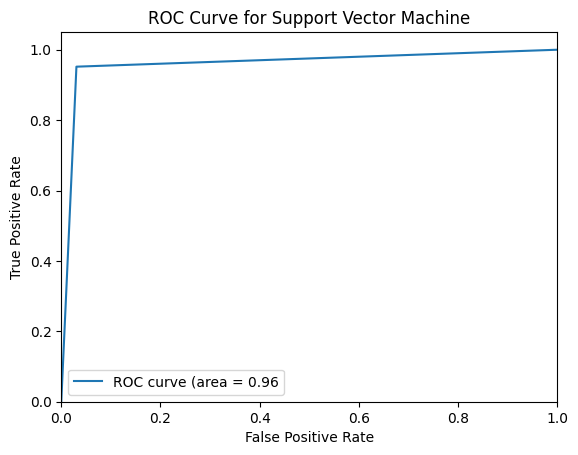

In [28]:
svm.plot_roc_curve()

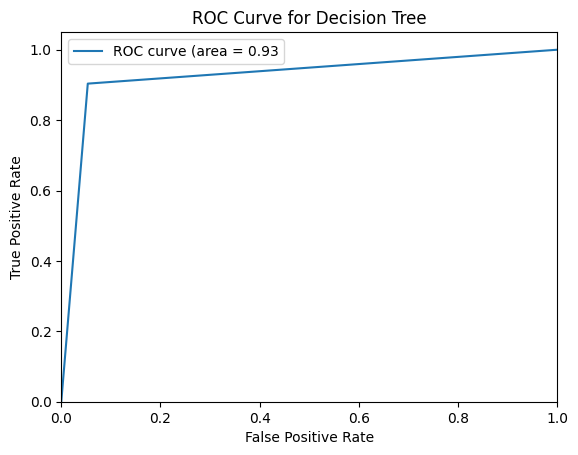

In [29]:
dt.plot_roc_curve()

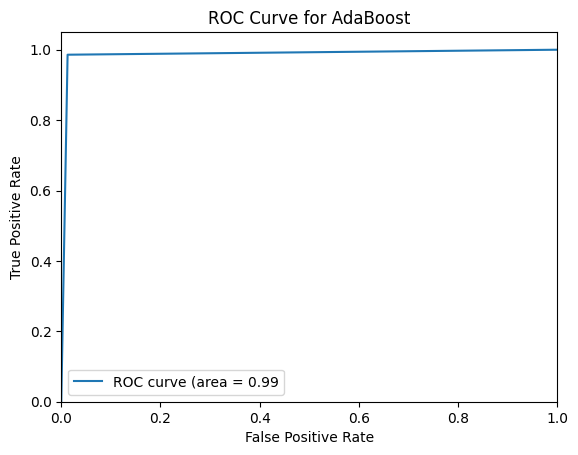

In [30]:
ada.plot_roc_curve()

#### 3.3 Precision-Recal Curve

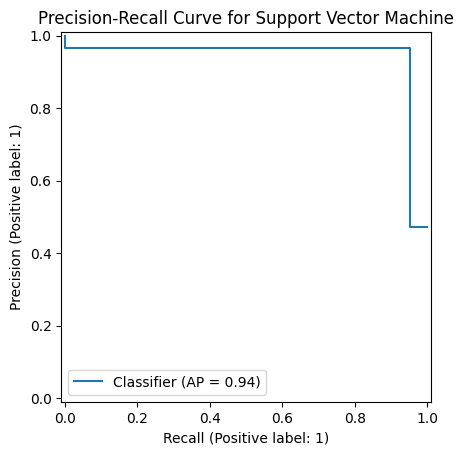

In [31]:
svm.plot_precision_recall()

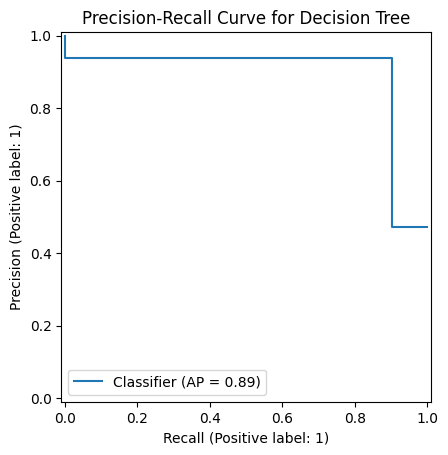

In [32]:
dt.plot_precision_recall()

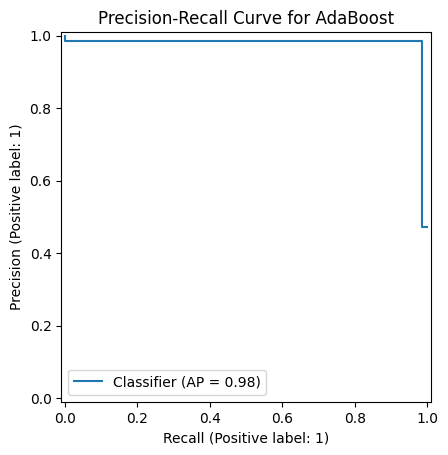

In [33]:
ada.plot_precision_recall()

### 3.2. Analysis

Based on the accuracy metrics, ROC curve, and precision-recall curve, the AdaBoost model shows the best performance with very high accuracy at 97.7%. Of the three models, the Decision Tree performed the worst at 92.6% accuracy compared to AdaBoost's accuracy and Support Vector Machine's (SVM) 96.1% accuracy.

Additionally, AdaBoost has higher precision scores than both SVM and Decision Tree on average and has the least misclassification of the three models.

---

## Saving the Models

In [34]:
# Save the optimized AdaBoost model
with open(ADA_PATH, "wb") as file:
    joblib.dump(ada_model, file)